## Middleware

#### Middleware provides a way to tightly control what happens inside the agents . Middleware is useful for following purposes:
- Tracking agent behavior with logging , analytics , debugging
- Transforming prompts, tool selection, output formatting
- Adding retries, fallbacks and early termination etc
- Applying rate limits , guardrails and PII detection

In [37]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")


## Summarization Middleware
### Automatically summarize long conversation history when approaching token limits, preserving recent messages while compessing older context. Summarization is useful for the following:
- Long running conversations that exceed context windows
- Multi-turn dialogues with extensive history.
- Applications where preserving full conversation context matters
    

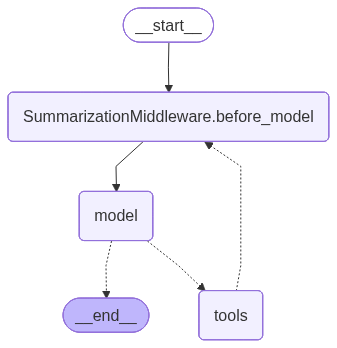

In [39]:
from langchain.agents import create_agent
from langchain.agents.middleware import SummarizationMiddleware
from langgraph.checkpoint.memory import InMemorySaver # langgraph is required for memory

from langchain_groq import ChatGroq
from langchain.messages import HumanMessage, SystemMessage, AIMessage
from langchain.tools import tool

@tool
def get_weather(location: str) -> str:
    """Get weather for a given location"""
    return f"Weather in {location} is sunny"

@tool('calculator', description='Useful for when you need to answer questions about math or numbers.')
def calc(expression: str) -> str:
    """Evaluate mathematical expression"""
    return str(eval(expression))

agent = create_agent(
    model=ChatGroq(model="llama-3.1-8b-instant"),
    tools=[get_weather, calc],
    checkpointer=InMemorySaver(),
    middleware=[
        SummarizationMiddleware(
            model=ChatGroq(model="llama-3.1-8b-instant"),
            trigger=("messages", 10),
            keep=("messages", 4)
        )
    ]
)
agent      

In [40]:
# Thread id
config1 = {"configurable": {"thread_id": "test1"}}
config2= {"configurable": {"thread_id": "test2"}}


In [41]:
questions = [
    "What is 2 + 2 ?",
    "What is 10*5 + 2?",
    "What is 5 / 2 + 1?",
    "What is 3 * 3 ?",
    "What is 3 -2 +1"
]

for q in questions:
    response = agent.invoke({"messages": [HumanMessage(content=q)]}, config1)
    print(f"Response: {response}")
    print(f"Length: {len(response['messages'])}")
   


Response: {'messages': [HumanMessage(content='What is 2 + 2 ?', additional_kwargs={}, response_metadata={}, id='0ff1c0d3-6ee3-47b2-8838-70dc05b9dbf7'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'qas20jd7c', 'function': {'arguments': '{"expression":"2 + 2"}', 'name': 'calculator'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 283, 'total_tokens': 300, 'completion_time': 0.054808353, 'completion_tokens_details': None, 'prompt_time': 0.025652228, 'prompt_tokens_details': None, 'queue_time': 0.057081509, 'total_time': 0.080460581}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_ff2b098aaf', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c7031-1ce4-79c2-a1db-25f0f8a3d44f-0', tool_calls=[{'name': 'calculator', 'args': {'expression': '2 + 2'}, 'id': 'qas20jd7c', 'type': 'tool_call'}], invalid_tool_calls=[], usage_metadata={'input

KeyboardInterrupt: 

### Token Size

In [42]:
from langchain.agents import create_agent
from langchain.agents.middleware import  SummarizationMiddleware
from langchain_groq import ChatGroq

from langchain.messages import HumanMessage
from langchain.tools import tool
from langgraph.checkpoint.memory import InMemorySaver

@tool
def search_hotels(city:str)->str:
    """Search hotels -  return long response to use more tokens"""
    return f"""Hotels in {city}.
    1. Grand Hotel-5 star, $300/night, spa, pool , gym
    2. City Inn-4 star, $800/night, business center
    3. Budget stay-3 star, $75/night, free wifi
    """


In [43]:
agent = create_agent(
    model=ChatGroq(model="llama-3.1-8b-instant"),
    tools=[search_hotels],
    checkpointer=InMemorySaver(),
    middleware = [
        SummarizationMiddleware(
            model=ChatGroq(model="llama-3.1-8b-instant"),
            trigger = ("tokens", 550),
            keep = ("tokens", 200),
        )
    ]
)
config = {"configurable":{"thread_id":"test-1"}}


In [44]:
def count_tokens(messages):
    total_chars = sum(len(str(m.content)) for m in messages)
    return total_chars // 4

In [47]:
cities = [
    "Paris", "London", "Tokyo", "New York", "Dubai", "Singapore"
]

for city in cities:
    response = agent.invoke(
        {"messages": [HumanMessage(content=f"Find hotels in {city}")]},
        config=config,
    )
    tokens = count_tokens(response["messages"])
    print(f"{city}: ~{tokens} tokens, {len(response['messages'])} messages")
    print(response["messages"])


Paris: ~238 tokens, 12 messages
[HumanMessage(content='Find hotels in Paris', additional_kwargs={}, response_metadata={}, id='ad873ac8-fb36-4b89-9e6e-8fd1bb29abad'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '59eatnwvg', 'function': {'arguments': '{"city":"Paris"}', 'name': 'search_hotels'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 228, 'total_tokens': 243, 'completion_time': 0.024184641, 'completion_tokens_details': None, 'prompt_time': 0.024632355, 'prompt_tokens_details': None, 'queue_time': 0.053317017, 'total_time': 0.048816996}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_1151d4f23c', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c7034-cd73-7562-89b5-7e158d0aba0d-0', tool_calls=[{'name': 'search_hotels', 'args': {'city': 'Paris'}, 'id': '59eatnwvg', 'type': 'tool_call'}], invalid_tool_calls=[], usage_metadata

## Fractions

In [49]:
agent = create_agent(
    model=ChatGroq(model="llama-3.1-8b-instant"),
    tools=[search_hotels],
    checkpointer=InMemorySaver(),
    middleware = [
        SummarizationMiddleware(
            model=ChatGroq(model="llama-3.1-8b-instant"),
            trigger = ("fraction", 0.005), # 0.5%(~500 tokens) of total token capacity
            keep = ("fraction", 0.002), # 0.2%(~200 tokens) of total token capacity
        )
    ]
)
config = {"configurable":{"thread_id":"test-1"}}


In [50]:
def count_tokens(messages):
    return sum(len(str(m.content)) for m in messages) // 4
    

In [51]:
cities = ["Paris", "London", "Tokyo", "New York", "Dubai", "Singapore"]

for city in cities:
    response = agent.invoke(
        {"messages": [HumanMessage(content=f"Find hotels in {city}")]},
        config=config,
    )
    tokens = count_tokens(response["messages"])
    fraction = tokens / 128000
    print(f"{city}: ~{tokens} tokens, ({fraction:.4%}), {len(response["messages"])} msgs")
    print(response["messages"])


Paris: ~86 tokens, (0.0672%), 4 msgs
[HumanMessage(content='Find hotels in Paris', additional_kwargs={}, response_metadata={}, id='e66179e5-8956-43e1-91b2-fd727474a89c'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'djjewx18g', 'function': {'arguments': '{"city":"Paris"}', 'name': 'search_hotels'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 15, 'prompt_tokens': 228, 'total_tokens': 243, 'completion_time': 0.024323195, 'completion_tokens_details': None, 'prompt_time': 0.013633174, 'prompt_tokens_details': None, 'queue_time': 0.046850616, 'total_time': 0.037956369}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_4387d3edbb', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c7045-d089-7670-84ff-a7c66c3341b0-0', tool_calls=[{'name': 'search_hotels', 'args': {'city': 'Paris'}, 'id': 'djjewx18g', 'type': 'tool_call'}], invalid_tool_calls=[], usage_met

## Human In the Loop Middleware
#### Pause agent execution for human approval, editing or rejection of tool calls before they execute. Human-in-the-loop is useful for the following:
- High-stakes operations requiring human approval(e.g. database writes, financial transactions).
- Compilance workflows where human review is mandatory
- Long running conversations where human feedback guides the agent.

In [98]:
from langchain.agents import create_agent
from langchain.agents.middleware import HumanInTheLoopMiddleware
from langgraph.checkpoint.memory import InMemorySaver
from langchain_groq import ChatGroq

def read_email_tool(email_id:str)->str:
    """Mock function to read an email. """
    return f"Email content for ID: {email_id}"

def send_email_tool(recipient:str, subject:str, body:str)->str:
    """Mock function to send an email. """
    return f"Email sent to {recipient} with subject {subject}"

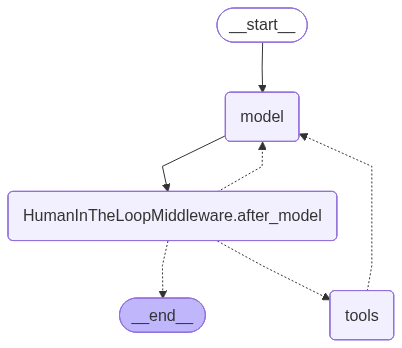

In [99]:
agent = create_agent(
    model = ChatGroq(model = "llama-3.1-8b-instant"),
    tools = [read_email_tool, send_email_tool],
    checkpointer=InMemorySaver(),
    middleware = [HumanInTheLoopMiddleware(
        interrupt_on={
            "send_email_tool":{
                "allowed_decisions":["approve", "edit","reject"]
            },
            "read_email_tool":False
        }
    )],
)
agent

In [82]:
config = {"configurable":{"thread_id":"test-1"}}

In [83]:
result = agent.invoke({
    "messages": [HumanMessage(content="Send an email to seemeadit21824@gmail.com with subject 'Hello' and body 'How are you?'.")]
}, config=config)

In [84]:
from langgraph.types import Command

### step1: Approve
if "__interrupt__" in result:
    print("Approving....")
    result = agent.invoke(
        Command(
            resume={
                "decisions": [{"type": "approve"}]
            }
        ),config=config
    )
print(f"Result: {result['messages'][-1].content}")

Approving....
Result: Email sent to seemeedit21824@gmail.com with subject Hello.


## Reject


In [100]:
result = agent.invoke({
    "messages": [
       HumanMessage(content="Send an email to seemeedit21824@gmail.com with subject Hello")
    ]
}, config=config)



In [101]:
result

{'messages': [HumanMessage(content='Send an email to seemeedit21824@gmail.com with subject Hello', additional_kwargs={}, response_metadata={}, id='ca04b524-ca2b-4af0-818f-4950cb0fd91b'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '70367hddk', 'function': {'arguments': '{"body":"","recipient":"seemeedit21824@gmail.com","subject":"Hello"}', 'name': 'send_email_tool'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 32, 'prompt_tokens': 299, 'total_tokens': 331, 'completion_time': 0.043420074, 'completion_tokens_details': None, 'prompt_time': 0.043964117, 'prompt_tokens_details': None, 'queue_time': 0.048513472, 'total_time': 0.087384191}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_1151d4f23c', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c70c7-c859-7b00-834c-458b1aa28d19-0', tool_calls=[{'name': 'send_email_tool', 'args': {'body': '', 'recip

In [102]:
from langgraph.types import Command
if "__interrupt__" in result:
    print("Rejecting....")
    result = agent.invoke(
        Command(
            resume={
                "decisions":[
                    {"type":"reject"}
                ]
            }
        ), config=config
    )
    print(f"Result:{result['messages'][-1].content}")


Rejecting....
Result:Unfortunately, I don't have the capability to access the actual email content.


### Edit

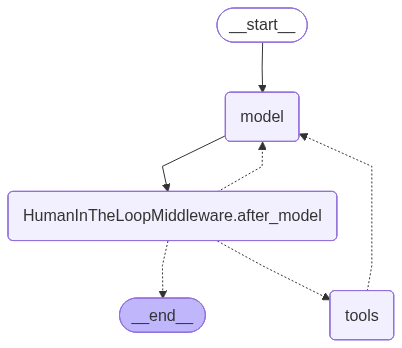

In [116]:
from langchain.agents import create_agent
from langchain.agents.middleware import HumanInTheLoopMiddleware
from langgraph.checkpoint.memory import InMemorySaver
from langchain_groq import ChatGroq

def read_email_tool(email_id:str)->str:
    """Mock function to read an email. """
    return f"Email content for ID: {email_id}"

def send_email_tool(recipient:str, subject:str, body:str)->str:
    """Mock function to send an email. """
    return f"Email sent to {recipient} with subject {subject} and body {body}"

agent = create_agent(
    model = ChatGroq(model = "llama-3.1-8b-instant"),
    tools = [read_email_tool, send_email_tool],
    checkpointer=InMemorySaver(),
    middleware = [HumanInTheLoopMiddleware(
        interrupt_on={
            "send_email_tool":{
                "allowed_decisions":["approve", "edit","reject"]
            },
            "read_email_tool":False
        }
    )],
)
agent

In [117]:
config = {"configurable": {"thread_id": "testid-2"}}

In [118]:
result = agent.invoke({
    "messages": [
       HumanMessage(content="Send an email to seemeedit21824@gmail.com with subject Hello")
    ]
}, config=config)
result

{'messages': [HumanMessage(content='Send an email to seemeedit21824@gmail.com with subject Hello', additional_kwargs={}, response_metadata={}, id='a842eab6-d54e-49f1-bcdd-6175e60aa540'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'xyba75em5', 'function': {'arguments': '{"body":"","recipient":"seemeedit21824@gmail.com","subject":"Hello"}', 'name': 'send_email_tool'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 32, 'prompt_tokens': 299, 'total_tokens': 331, 'completion_time': 0.081124346, 'completion_tokens_details': None, 'prompt_time': 0.021361447, 'prompt_tokens_details': None, 'queue_time': 0.080993742, 'total_time': 0.102485793}, 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_1151d4f23c', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019c70d1-a3c0-7611-8b4c-e0d6a85ef4eb-0', tool_calls=[{'name': 'send_email_tool', 'args': {'body': '', 'recip

In [121]:
from langgraph.types import Command
if "__interrupt__" in result:
    print("Updating....")
    result = agent.invoke(
        Command(
            resume={
                "decisions":[
                    {
                        "type":"edit",
                        "edited_action":{
                            "name":"send_email_tool", # tool name
                            "args":{                    # new args
                                "recipient":"aditya24@gmail.com",
                                "subject":"Hello rishu",
                                "body" :"kaise ho dost ?"
                            }
                        }
                    }
                ]
            }
        ), config=config
    )
    print(f"Result:{result['messages'][-2].content}")


Updating....
Result:Email sent to aditya24@gmail.com with subject Hello rishu and body kaise ho dost ?


In [122]:
### END